In [1]:
"""
Scipy version > 0.18 is needed, due to 'mode' option from scipy.misc.imread function
"""

import os
import glob
import h5py
import random
import matplotlib.pyplot as plt

from PIL import Image  # for loading images as YCbCr format
import scipy.misc
import scipy.ndimage
import numpy as np

import tensorflow as tf

FLAGS = tf.app.flags.FLAGS

def read_data(path):
  """
  Read h5 format data file
  
  Args:
    path: file path of desired file
    data: '.h5' file format that contains train data values
    label: '.h5' file format that contains train label values
  """
  with h5py.File(path, 'r') as hf:
    data = np.array(hf.get('data'))
    label = np.array(hf.get('label'))
    return data, label

def preprocess(path, scale=3):
  """
  Preprocess single image file 
    (1) Read original image as YCbCr format (and grayscale as default)
    (2) Normalize
    (3) Apply image file with bicubic interpolation

  Args:
    path: file path of desired file
    input_: image applied bicubic interpolation (low-resolution)
    label_: image with original resolution (high-resolution)
  """
  image = imread(path, is_grayscale=True)
  label_ = modcrop(image, scale)

  # Must be normalized
  image = image / 255.
  label_ = label_ / 255.

  input_ = scipy.ndimage.interpolation.zoom(label_, 1.0/scale, prefilter=False)
  input_ = scipy.ndimage.interpolation.zoom(input_, scale, prefilter=False)

  return input_, label_

def prepare_data(sess, dataset):
  """
  Args:
    dataset: choose train dataset or test dataset
    
    For train dataset, output data would be ['.../t1.bmp', '.../t2.bmp', ..., '.../t99.bmp']
  """
  if FLAGS.is_train:
    filenames = os.listdir(dataset)
    data_dir = os.path.join(os.getcwd(), dataset)
    data = glob.glob(os.path.join(data_dir, "*.bmp"))
  else:
    data_dir = os.path.join(os.sep, os.path.join(os.getcwd(), dataset), "Set5")
    data = glob.glob(os.path.join(data_dir, "*.bmp"))

  return data

def make_data(sess, data, label):
  """
  Make input data as h5 file format
  Depending on 'is_train' (flag value), savepath would be changed.
  """
  if FLAGS.is_train:
    savepath = os.path.join(os.getcwd(), 'checkpoint/train.h5')
  else:
    savepath = os.path.join(os.getcwd(), 'checkpoint/test.h5')

  with h5py.File(savepath, 'w') as hf:
    hf.create_dataset('data', data=data)
    hf.create_dataset('label', data=label)

def imread(path, is_grayscale=True):
  """
  Read image using its path.
  Default value is gray-scale, and image is read by YCbCr format as the paper said.
  """
  if is_grayscale:
    return scipy.misc.imread(path, flatten=True, mode='YCbCr').astype(np.float)
  else:
    return scipy.misc.imread(path, mode='YCbCr').astype(np.float)

def modcrop(image, scale=3):
  """
  To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
  
  We need to find modulo of height (and width) and scale factor.
  Then, subtract the modulo from height (and width) of original image size.
  There would be no remainder even after scaling operation.
  """
  if len(image.shape) == 3:
    h, w, _ = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w, :]
  else:
    h, w = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w]
  return image

def input_setup(sess, config):
  """
  Read image files and make their sub-images and saved them as a h5 file format.
  """
  # Load data path
  if config.is_train:
    data = prepare_data(sess, dataset="Train")
  else:
    data = prepare_data(sess, dataset="Test")
    print data

  sub_input_sequence = []
  sub_label_sequence = []
  padding = abs(config.image_size - config.label_size) / 2 # 6

  if config.is_train:
    for i in xrange(len(data)):
      input_, label_ = preprocess(data[i], config.scale)

      if len(input_.shape) == 3:
        h, w, _ = input_.shape
      else:
        h, w = input_.shape

      for x in range(0, h-config.image_size+1, config.stride):
        for y in range(0, w-config.image_size+1, config.stride):
          sub_input = input_[x:x+config.image_size, y:y+config.image_size] # [33 x 33]
          sub_label = label_[x+padding:x+padding+config.label_size, y+padding:y+padding+config.label_size] # [21 x 21]

          # Make channel value
          sub_input = sub_input.reshape([config.image_size, config.image_size, 1])  
          sub_label = sub_label.reshape([config.label_size, config.label_size, 1])

          sub_input_sequence.append(sub_input)
          sub_label_sequence.append(sub_label)

  else:
    input_, label_ = preprocess(data[4], config.scale)
    print data[4]
    print input_.shape

    if len(input_.shape) == 3:
      h, w, _ = input_.shape
    else:
      h, w = input_.shape

    # Numbers of sub-images in height and width of image are needed to compute merge operation.
    nx = ny = 0 
    for x in range(0, h-config.image_size+1, config.stride):
      nx += 1; ny = 0
      for y in range(0, w-config.image_size+1, config.stride):
        ny += 1
        sub_input = input_[x:x+config.image_size, y:y+config.image_size] # [33 x 33]
        sub_label = label_[x+padding:x+padding+config.label_size, y+padding:y+padding+config.label_size] # [21 x 21]
        
        sub_input = sub_input.reshape([config.image_size, config.image_size, 1])  
        sub_label = sub_label.reshape([config.label_size, config.label_size, 1])

        sub_input_sequence.append(sub_input)
        sub_label_sequence.append(sub_label)

  """
  len(sub_input_sequence) : the number of sub_input (33 x 33 x ch) in one image
  (sub_input_sequence[0]).shape : (33, 33, 1)
  """
  # Make list to numpy array. With this transform
  arrdata = np.asarray(sub_input_sequence) # [?, 33, 33, 1]
  arrlabel = np.asarray(sub_label_sequence) # [?, 21, 21, 1]

  make_data(sess, arrdata, arrlabel)

  if not config.is_train:
    return nx, ny
    
def imsave(image, path):
  return scipy.misc.imsave(path, image)

def merge(images, size):
  h, w = images.shape[1], images.shape[2]
  img = np.zeros((h*size[0], w*size[1], 1))
  for idx, image in enumerate(images):
    i = idx % size[1]
    j = idx // size[1]
    img[j*h:j*h+h, i*w:i*w+w, :] = image

  return img

In [18]:
im = imread('Test/Set5/butterfly_GT.bmp')

In [21]:
imsave(im, 'ololo.bmp')

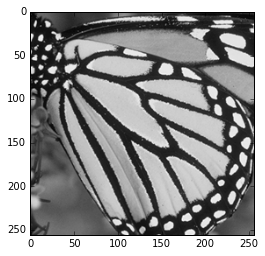

In [20]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('Test/Set5/butterfly_GT.bmp', 'r')
# imshow(np.asarray(pil_im))
imshow(im, cmap='gray')

In [13]:
np.asarray(pil_im)[:,:,1].shape

(256, 256)

In [7]:
pil_im = Image.open('Test/Set5/butterfly_GT.bmp', 'r')
pil_im.show()